In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage

In [3]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio=0.7):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyPCA(X, numComponents=30):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=15, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train


def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if wasPCAapplied:
        with open("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open("../preprocessedData/XtrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("../preprocessedData/XtestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("../preprocessedData/ytrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("../preprocessedData/ytestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            
            
            
            

In [4]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


In [5]:
X, y = loadIndianPinesData()

In [6]:
X,pca = applyPCA(X,numPCAcomponents)

In [7]:
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)

In [8]:
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)

In [9]:
X_train, y_train = oversampleWeakClasses(X_train, y_train)

In [10]:
X_train = AugmentData(X_train)

In [11]:
savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numPCAcomponents,testRatio = testRatio)

# Train the model

In [12]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
#K.set_image_dim_ordering('th')
from keras.utils import np_utils
#from sklearn.cross_validation import StratifiedKFold

Using TensorFlow backend.


In [24]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral
import matplotlib
%matplotlib inline

In [13]:
PATH = os.getcwd()
print (PATH)

C:\Users\Sushmita\Documents\Minor project docs\HSI - Classification\Classification-of-Hyperspectral-Image-master


In [14]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


In [15]:
# Global Variables
#windowSize = 5
#numPCAcomponents = 30
#testRatio = 0.25

# Load Training Dataset

In [16]:
X_train = np.load("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio)  + ".npy")

y_train = np.load("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

In [17]:
#number of images
X_train.shape

(29685, 5, 5, 30)

In [18]:
# Reshape into (numberofsamples, channels, height, width)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))

In [19]:
# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)

In [20]:
# Define the input shape 
input_shape= X_train[0].shape
print(input_shape)

(30, 5, 5)


In [21]:
# number of filters
C1 = 3*numPCAcomponents

In [22]:
# Define the model
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

In [ ]:
model.summary()

In [23]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [25]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])


# Define the neccesary functions for later use

In [27]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'Data')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
               ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
               'Stone-Steel-Towers']

    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy


def applyPCA(X, numPCAcomponents=30):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numPCAcomponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numPCAcomponents))
    return newX, pca

def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [28]:
X_test = np.load("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


y_test = np.load("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")


In [29]:
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [30]:
history1=model.fit(X_train, y_train, epochs = 50, batch_size = 32,validation_data=(X_test, y_test), shuffle=True)


Train on 29685 samples, validate on 2563 samples
Epoch 1/50
29685/29685 [==============================] - 107s 4ms/step - loss: 2.5061 - accuracy: 0.2539 - val_loss: 2.4341 - val_accuracy: 0.3441
Epoch 2/50
29685/29685 [==============================] - 115s 4ms/step - loss: 1.7243 - accuracy: 0.5379 - val_loss: 1.6383 - val_accuracy: 0.5915
Epoch 3/50
29685/29685 [==============================] - 115s 4ms/step - loss: 1.1410 - accuracy: 0.6580 - val_loss: 1.1782 - val_accuracy: 0.6602
Epoch 4/50
29685/29685 [==============================] - 114s 4ms/step - loss: 0.8675 - accuracy: 0.7239 - val_loss: 0.9901 - val_accuracy: 0.6918
Epoch 5/50
29685/29685 [==============================] - 114s 4ms/step - loss: 0.7180 - accuracy: 0.7668 - val_loss: 0.8595 - val_accuracy: 0.7292
Epoch 6/50
29685/29685 [==============================] - 113s 4ms/step - loss: 0.6340 - accuracy: 0.7901 - val_loss: 0.7588 - val_accuracy: 0.7624
Epoch 7/50
29685/29685 [==============================] - 113s

In [31]:
import h5py
from keras.models import load_model

In [32]:
model.save('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [33]:
# evaluate the model
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)

In [34]:
print("Train accuracy : ",train_acc)
print("Test accuracy : ",test_acc)

Train accuracy :  [0.05625393256213763, 0.9848408102989197]
Test accuracy :  [0.19740034312800508, 0.9340616464614868]


In [35]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and Validation Accuracy')

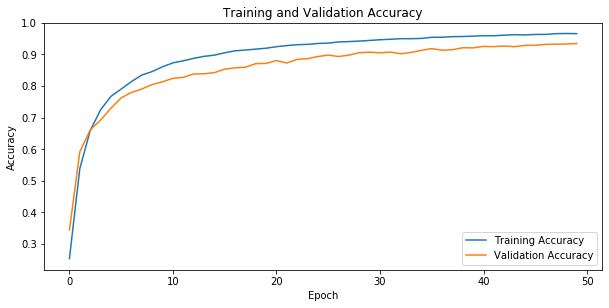

In [36]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']



plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



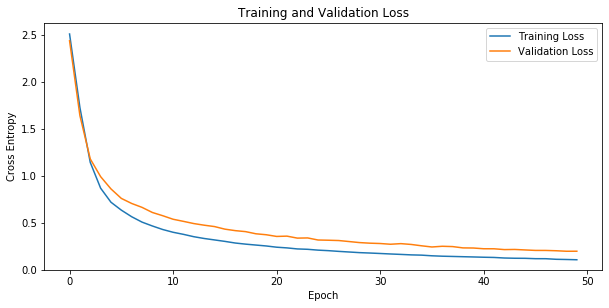

In [37]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [38]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.86      0.89      0.87       357
           2       0.92      0.94      0.93       208
           3       0.95      0.97      0.96        59
           4       0.98      0.96      0.97       121
           5       0.99      1.00      0.99       183
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00         5
           9       0.85      0.93      0.89       243
          10       0.93      0.87      0.90       614
          11       0.96      0.96      0.96       148
          12       0.98      1.00      0.99        51
          13       1.00      0.99      0.99       316
          14       0.92      0.97      0.94        97
          15       1.00      1.00      1.00        23

    accuracy                           0.93      2563
   macro avg       0.96   

In [39]:
# load the model architecture and weights
model = load_model('my_model' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

In [40]:
# Using the pretrained model make predictions and print the results into a report
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

2563/2563 [==============================] - 4s 2ms/step


# Build the Classification Maps

In [41]:
# load the original image
X, y = loadIndianPinesData()

In [42]:
X,pca = applyPCA(X,numPCAcomponents)

In [43]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numPCAcomponents = numPCAcomponents

In [44]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        target = y[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[int(i+PATCH_SIZE/2)][int(j+PATCH_SIZE/2)] = prediction+1

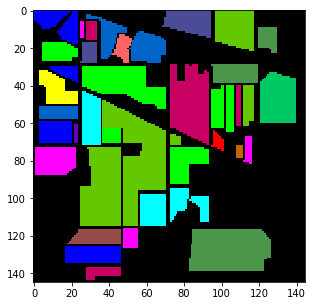

In [45]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

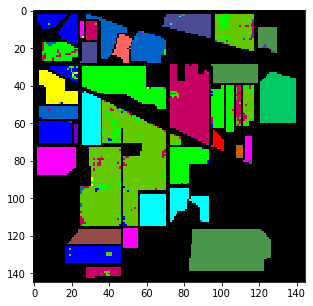

In [46]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))